In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NN3FeaturesModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

In [2]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')

def load_data(raw, dataset='', validation=False):
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t7_data/{key}.pkl')
    return raw[key]

In [3]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

In [4]:
# # incase i need to save the current model in memory
# def save_model_with_config(train_config, sub_model_key, **kwargs):
#     path = train_config['model_path']
#     prefix = train_config['model_prefix']
#     f = f"{path}/{prefix}{sub_model_key}.pth"
#     torch.save(kwargs, f)

In [5]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [6]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [47]:
train_config = {
    'dataset' : 'sample_200_', # '', 'sample_', 'secret_'
    'model_prefix' : "T7_2_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t7_models",
    'device' : 'cpu',
}

In [28]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
y_cols = ['y_SAT_RX', 'y_SAT_RY', 'y_SAT_RZ']
y_test = y_test[y_cols]

Loading data to cache for: sample_200_test
CPU times: user 728 ms, sys: 835 ms, total: 1.56 s
Wall time: 1.18 s


In [29]:
model_configs = {
    'position': { },
    'velocity': { },
}

Loading existing model
position
MSELoss()


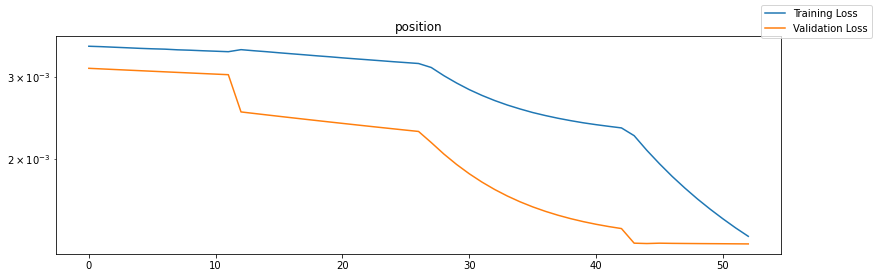

,train loss,validation loss
43,0.002245841954,0.001319410641
44,0.002088783995,0.001317033626
45,0.001954211104,0.001319314586
46,0.001835770485,0.001318105063
47,0.001732873314,0.001317413565
48,0.001641278620,0.001316747320
49,0.001560620570,0.001316196296
50,0.001488384785,0.001315690032
51,0.001422981114,0.001315077531
52,0.001364900631,0.001314539531


Epoch 53
    Test set MAE (L1) loss: 0.0076372308973112375
    Test set MSE (L2) loss: 0.0015353352217335478
Loading existing model
No data for velocity


,y_SAT_RX,y_SAT_RY,y_SAT_RZ,X_SGP4_SAT_RX,X_SGP4_SAT_RY,X_SGP4_SAT_RZ,y_SAT_RX_pred,y_SAT_RY_pred,y_SAT_RZ_pred
0,-0.278770563185,1.026923797242,-0.000822244846,-0.278660272173,1.027016338683,-0.001047475095,-0.282459437847,1.020537018776,-0.001961993054
1,-0.175395993702,1.049692253230,-0.000001031640,-0.175091333692,1.049715938684,-0.000784553302,-0.178890496492,1.043236732483,-0.001699141925
2,-0.125969005786,1.056628141881,0.000218924272,-0.126325326777,1.056764451024,0.000907323324,-0.130124419928,1.050285220146,-0.000007164665
3,-0.094794682753,1.059871770351,-0.000036306587,-0.094828746229,1.059894744806,0.000048207596,-0.098627813160,1.053415536880,-0.000866332557
4,-0.013679499544,1.064030906058,-0.000030133294,-0.013820324825,1.064041145700,0.000209839004,-0.017619386315,1.057561874390,-0.000704708567
...,...,...,...,...,...,...,...,...,...
479660,-0.753290479244,0.785284023516,-0.000001247558,-0.413716750486,0.942797589733,-0.442376669467,-0.417515277863,0.936318695545,-0.443291723728
479661,-0.742980631570,0.795543793771,-0.000000704162,-0.461521894794,0.944096985349,-0.383801063991,-0.465320318937,0.937618017197,-0.384716063738
479662,-0.719214177844,0.818955311979,0.000000094797,-0.089944629093,0.895096134565,-0.653679622577,-0.093743100762,0.888617277145,-0.654594659805
479663,-0.701667344477,0.835284557127,-0.000000046088,0.069621862032,0.822010205911,-0.727265388983,0.065823473036,0.815531432629,-0.728180527687


In [65]:
# Create or load all new sub models here if needed.
# sample_idx = random.sample(list(X_test.index), 10000)
sample_idx = X_test.index
all_models = {}
display_data = []
for sub_key in model_configs.keys():
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    try:
        tl, vl = zip(*mean_losses)
        print(f'{sub_key}')
    except:
        print(f"No data for {sub_key}")
        continue

    fig,ax = plt.subplots(figsize=(13,4))
    print(loss_func)
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
    ax.set_yscale('log')
    ax.set_ylim((ax.get_ylim()[0], min(1,ax.get_ylim()[1])))
    fig.legend()
    plt.show()
    display(pd.DataFrame(mean_losses, columns=['train loss','validation loss']).tail(10))

    trained_model = model
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    display_data.append(y_sample)
    display_data.append(X_test.loc[sample_idx][['X_SGP4_SAT_RX','X_SGP4_SAT_RY','X_SGP4_SAT_RZ']])
    display_data.append(y_sample_pred_df.add_suffix('_pred'))
    print('==============================')
df = pd.concat(display_data, axis=1)
display(df)
# df['error'] = (np.abs(df.iloc[:,0]*360 - df.iloc[:,1]*360))%360
# df['error'] = np.minimum(360-df.error,df.error)
# display(df.error.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999]))
# df['epoch_diff'] = X_sample.X_delta_EPOCH
# display(df.error.describe())